In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [48]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
print("x_train.shape:", x_train.shape)
print("y_train.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape (50000,)


In [94]:
i = Input(shape=x_train[0].shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)  # NEW
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)  # NEW
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)  # NEW

x = GlobalMaxPooling2D()(x)  # NEW
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(10, activation='softmax')(x)

model = Model(i, x)

In [95]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
# plot_model(model, to_file="model.png", show_shapes=True)

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_90 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_91 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 16, 16, 32)      

In [96]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    height_shift_range=0.1, 
    horizontal_flip=True,
    width_shift_range=0.1)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)  # Early stop if no longer improving
filepath = 'cnn-cifar10-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

r = model.fit(
        train_generator, 
        validation_data=(x_test, y_test), 
        steps_per_epoch=steps_per_epoch, 
        epochs=200, 
        callbacks=[checkpoint, early_stop])

Epoch 1/200
1562/1562 [==============================] - ETA: 0s - loss: 1.9033 - accuracy: 0.3043
Epoch 00001: val_accuracy improved from -inf to 0.44790, saving model to cnn-cifar10-01-0.45.hdf5
1562/1562 [==============================] - 26s 16ms/step - loss: 1.9033 - accuracy: 0.3043 - val_loss: 1.5145 - val_accuracy: 0.4479
Epoch 2/200
1561/1562 [============================>.] - ETA: 0s - loss: 1.5610 - accuracy: 0.4189
Epoch 00002: val_accuracy improved from 0.44790 to 0.49000, saving model to cnn-cifar10-02-0.49.hdf5
1562/1562 [==============================] - 25s 16ms/step - loss: 1.5610 - accuracy: 0.4188 - val_loss: 1.3854 - val_accuracy: 0.4900
Epoch 3/200
1559/1562 [============================>.] - ETA: 0s - loss: 1.4207 - accuracy: 0.4793
Epoch 00003: val_accuracy improved from 0.49000 to 0.50540, saving model to cnn-cifar10-03-0.51.hdf5
1562/1562 [==============================] - 25s 16ms/step - loss: 1.4207 - accuracy: 0.4794 - val_loss: 1.3430 - val_accuracy: 0.505

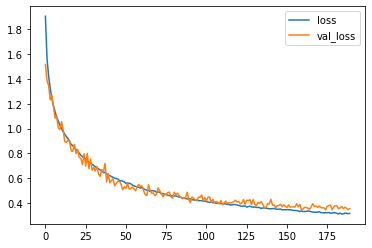

In [97]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

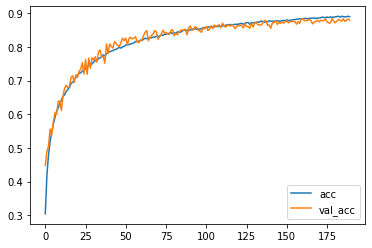

In [98]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [93]:
%rm -f cnn-cifar10*